In [37]:
import pandas as pd
import seaborn as sns
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


Lendo a base de dados e formatando as colunas

In [38]:
CO_dataset = pd.read_csv('../DataBases/crude_oil.csv')
CO_dataset.rename(columns={' Value': 'value' },inplace=True)
CO_dataset.dropna(inplace=True)


Função de evaluate do modelo ARIMA. Os parâmetros de entrada são a lista de valores da variável objetivo e uma tupla com os hiperparâmetros p, d e q. A função retorna um dicionário com a raíz do erro quadrático médio, uma lista com os valores da base de teste e uma lista com os valores preditos da base de teste. 

In [39]:
def Arima(dataset:list, arima_order: tuple) -> dict:
    from sklearn.metrics import mean_absolute_error

    train = dataset[:-3]
    test = dataset[-3:]
    history = [x for x in train]
    predictions = list()

    for i in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()

        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[i])

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()

    mae = (mean_absolute_error(test, predictions))
    return (model_fit,  mae, test, predictions)



    

Função de pesquisa de grade: a função a seguir recebe os dados com a variável objetivo do forecast, uma grade de valores para cada um dos parametros a ser testada (p,d e q) e em seguida faz o evaluate da função arima para cada uma das combinações de parâmetros. Após os testes, a função retorna a combinação de hiperparâmetros que devolve o melhor score.

In [40]:
def grid_search_model(dataset: list, p_value:list, d_value: list, q_value: list, time_range: list):
    best_score, best_config = float("inf"), None

    for year in time_range:
        dataset = dataset[dataset.Year >= year]    
        for p in p_value:
            for d in d_value:
                for q in q_value:
                    order=(p,d,q)
                    try:
                        model_fit,  mae, test, predictions = Arima(dataset.value.values, order)
                        if mae < best_score:
                            best_score = mae
                            best_config = order
                            best_start_year = year
                            print(
                                f'ARIMA{best_config}, mae= {best_score}, year = {year}'
                            )
                    except:
                        continue
    print(f'BEST ARIMA{best_config}, BEST START YEAR = {best_start_year}, MAE= {best_score}')
    return(best_config, best_score, best_start_year)


Função de agrupamento: agrupa os dados por mês ou semana (default mês)

In [41]:
def group(dataset:pd.DataFrame, period: str = 'm')-> pd.DataFrame:
    dataset.Date = pd.to_datetime(dataset.Date)
    Year = dataset.Date.dt.year
    month= dataset.Date.dt.month
    week= dataset.Date.dt.isocalendar().week
    grouped_df =dataset.copy()

    if period== 'm':
        grouped_df['Year'] = Year
        grouped_df['Month'] = month
        grouped_df=grouped_df.groupby(['Year', 'Month']).mean()

        grouped_df['Date'] = [f'{year}-{month}' for year, month in grouped_df.index]
        
    elif period== 'w':
        grouped_df['Year'] = Year
        grouped_df['Month'] = month
        grouped_df['Week'] = week
        grouped_df=grouped_df.groupby(['Year', 'Month', 'week']).mean()

        grouped_df['Date'] = [f'{year}-{month}-{week}' for year, month, week in grouped_df.index]

    return grouped_df

DEFININDO OS PARÂMETROS DE BUSCA

In [42]:
# evaluate parameters
time_range = range(2015,2023)
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
grouped_cd_series = group(CO_dataset)
grouped_cd_series.reset_index(inplace=True)
# best_config, best_score , best_start_year = grid_search_model(grouped_cd_series, p_values, d_values, q_values, time_range)


C:\Users\User\AppData\Local\Temp\ipykernel_8660\2724665445.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df=grouped_df.groupby(['Year', 'Month']).mean()


In [43]:
grouped_cd_series

,Year,Month,value,Date
0,2010,3,81.485000,2010-3
1,2010,4,84.292857,2010-4
2,2010,5,73.743500,2010-5
3,2010,6,75.335909,2010-6
4,2010,7,76.319524,2010-7
...,...,...,...,...
152,2022,11,84.085000,2022-11
153,2022,12,76.848636,2022-12
154,2023,1,78.313636,2023-1
155,2023,2,76.845000,2023-2


CHAMANDO O MODELO ARIMA COM OS MELHORES PARÂMETROS ENCONTRADOS

In [44]:
best_start_year = 2010
grouped_cd_series = grouped_cd_series[grouped_cd_series.Year >=  best_start_year] 
best_config = (2,1,2)

model_fit, mae, test, predictions = Arima(grouped_cd_series.value.values, best_config)



PLOT DOS DIAGNÓSTICOS DO MODELO PARA A SÉRIE

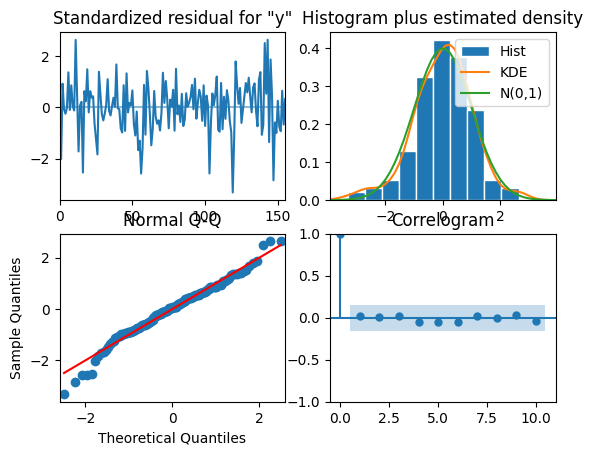

In [45]:
model_fit.plot_diagnostics()
plt.show()

QQplot

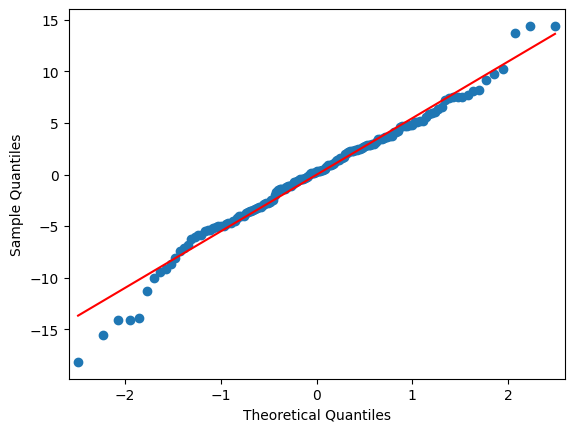

In [46]:
import numpy as np
import statsmodels.api as sm
import pylab as py
from scipy.stats.distributions import norm
import matplotlib.pyplot as plt
error =grouped_cd_series.value.values[1:] - model_fit.predict()[1:]

sm.qqplot(error, line='s')

plt.show()

In [47]:
avaliation_df = [grouped_cd_series.value.values[:], model_fit.predict()]
df = pd.DataFrame(avaliation_df).T
df

,0,1
0,81.485000,0.000000
1,84.292857,81.485721
2,73.743500,85.030232
3,75.335909,70.224808
4,76.319524,76.682306
...,...,...
152,84.085000,88.288997
153,76.848636,81.942287
154,78.313636,74.772462
155,76.845000,80.519965


<function matplotlib.pyplot.show(close=None, block=None)>

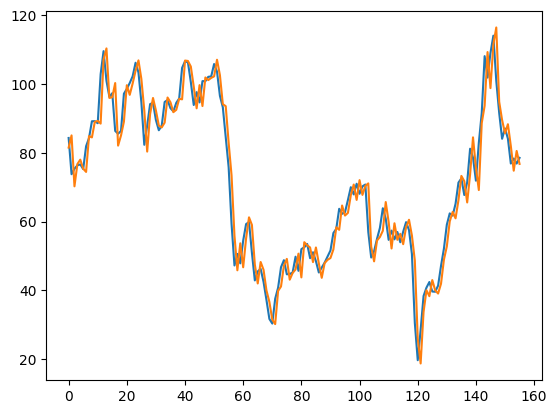

In [48]:
sns.lineplot(grouped_cd_series.value.values[1:])
sns.lineplot(model_fit.predict()[1:])
plt.show

In [49]:

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(grouped_cd_series.value.values[2:],model_fit.predict()[2:])
mape = mean_absolute_percentage_error(grouped_cd_series.value.values[2:],model_fit.predict()[2:])


print(f'mae: {mae}, mape: {mape}')

mae: 4.211480146382325, mape: 0.06760722987751075


RESULTADOS COM A BASE DE TESTE:


<Axes: >

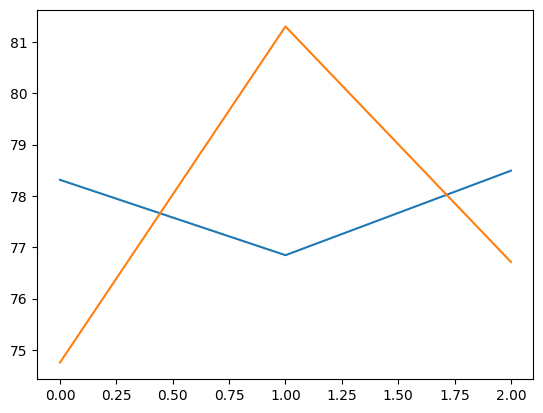

In [50]:
sns.lineplot(test)
sns.lineplot(predictions)


In [51]:
mae = mean_absolute_error(predictions,test)
mape = mean_absolute_percentage_error(predictions,test)
print(f'mae: {mae}, mape: {mape}')

mae: 3.266160979173795, mape: 0.04188780910494876


<Axes: >

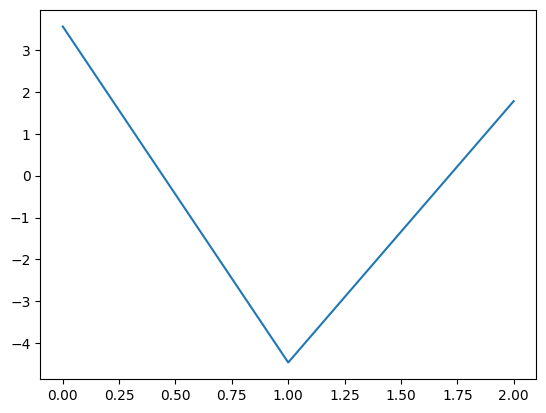

In [52]:
ruido = test - predictions
sns.lineplot(ruido)

Avaliando o modelo e criando excel


In [53]:
Avaliation = grouped_cd_series.copy()
Avaliation.index = Avaliation.Date
Avaliation.drop(columns=['Year', 'Month','Date'], inplace=True)
Avaliation['Model_fit'] = model_fit.predict()
Avaliation['Test_Predictions'] = [None for x in model_fit.predict()[3:]] + predictions

mae_test = [mean_absolute_error(predictions,test)]
mape_test = [mean_absolute_percentage_error(predictions,test)]
mae_train_base = [mean_absolute_error(grouped_cd_series.value.values[1:],model_fit.predict()[1:])]
mape_train_base = [mean_absolute_percentage_error(grouped_cd_series.value.values[1:],model_fit.predict()[1:])]


mae_test_list = mae_test + [None for i in range(len(Avaliation.value.values)-1)]
mape_test_list = mape_test + [None for i in range(len(Avaliation.value.values)-1)]

mae_train_list = mae_train_base + [None for i in range(len(Avaliation.value.values)-1)]
mape_train_list = mape_train_base + [None for i in range(len(Avaliation.value.values)-1)]

Avaliation['mae_base_test'] = mae_test_list
Avaliation['mape_base_test'] = mape_test_list
Avaliation['mae_train_base'] = mae_train_list
Avaliation['mape_train_base'] = mape_train_list


    

Avaliation
# Avaliation.to_csv(f'ARIMA{best_config}.csv', header=True, index=True)


,value,Model_fit,Test_Predictions,mae_base_test,mape_base_test,mae_train_base,mape_train_base
Date,,,,,,,
2010-3,81.485000,0.000000,NaN,3.266161,0.041888,4.202478,0.067387
2010-4,84.292857,81.485721,NaN,NaN,NaN,NaN,NaN
2010-5,73.743500,85.030232,NaN,NaN,NaN,NaN,NaN
2010-6,75.335909,70.224808,NaN,NaN,NaN,NaN,NaN
2010-7,76.319524,76.682306,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-11,84.085000,88.288997,NaN,NaN,NaN,NaN,NaN
2022-12,76.848636,81.942287,NaN,NaN,NaN,NaN,NaN
2023-1,78.313636,74.772462,74.753186,NaN,NaN,NaN,NaN


In [54]:
Avaliation

,value,Model_fit,Test_Predictions,mae_base_test,mape_base_test,mae_train_base,mape_train_base
Date,,,,,,,
2010-3,81.485000,0.000000,NaN,3.266161,0.041888,4.202478,0.067387
2010-4,84.292857,81.485721,NaN,NaN,NaN,NaN,NaN
2010-5,73.743500,85.030232,NaN,NaN,NaN,NaN,NaN
2010-6,75.335909,70.224808,NaN,NaN,NaN,NaN,NaN
2010-7,76.319524,76.682306,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-11,84.085000,88.288997,NaN,NaN,NaN,NaN,NaN
2022-12,76.848636,81.942287,NaN,NaN,NaN,NaN,NaN
2023-1,78.313636,74.772462,74.753186,NaN,NaN,NaN,NaN
